## **Building graphs for chatbots**

We'll learn how to create custom chatbots using LangGraph. We'll first the states that manage __Workflow management__, which are
1. Graph states
2. Agent states

Then we'll build chatbots using 
1. Nodes
2. Edges

### **Graph and agent states**

In LangGraph, __Graph State__
- Organizes different tasks, such as
  - Tool use
  - LLM calls
- Order of tasks = __workflow__

The graph uses __Agent State__ to
- Tracks agent's progress
- Logs task completion

### **Building an agent with LangGraph**

Let's start by building an education chatbot that uses an LLM to answer questions.

We only need three nodes and two edges to get started.

<div style="display: flex;">
    <!-- Left Column -->
    <div style="width: 45%; padding: 10px;">
    In LangGraph, nodes represent
    <ul> 
       <li>Functions or actions, such as </li>
        <ul>
          <li>response</li>
          <li>tool calls</li>
        </ul>
    </ul>
    while edges define the connections between these nodes. <br><br>
    Here, and edge connects the Start of the workflow to the Chatbot node, and another edge connects the Chatbot to the End of the workflow. <br><br>
    The START and END nodes to define the start and the end of the workflow will be directly imported from LangGraph.
    </div>
    <!-- Right Column -->
    <div style="width: 48%; padding: 10px;">
        <img src='./images/2n1e.png' width=33%>
    </div>
</div>

Let's build the full graph.

### **Building graph and agent states**

We'll need the following modules:

```python
# Modules for structuring text
from typing import Annotated
from typing_extensions import TypedDict

# LangGraph modules for defining graphs
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_message

# Module for setting uo OpenAI
from langchain_openai import ChatOpenAI
```

The `Annotated` and `TypedDict` modules will help organize the chatbot's text data.

`StateGraph`, `START`, and `END` will be needed to set up our chatbot's workflow and add text messages.

To get started,
1. we'll set OpenAI as our `llm`. 
2. Then we'll create an agent state called `State` that accepts `TypedDict` to structure messages. 
   - We'll define `messages` as a `list` that will store all text interactions with the chatbot. The `Annotated` type, combined with `add_messages`, ensures that new messages are added to the list with metadata. 
3. Next, we'll initialze a `StateGraph()` called `graph_builder` and pass in our `State` structure. The `graph_builder` will organize the nodes and edges in the chatbot's workflow.

```python
# Define the llm
llm = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

# Define the State
class State(TypedDict):

    # Define messages with metadata
    messages: Annotated[list, add_messages]
  
# Initialize StateGraph
graph_builder = StateGraph(State)
```

### **Adding nodes and edges**

Let's now define the main function node called "`chatbot`" that accepts the State class. Using the `llm.invoke()` method, it'll use the "`messages`" content on the state dictionary to generate a response based on the conversation so far. This chatbot node can then be added to the `graph_builder` using the `.add_node()` method, coupled with the label "`chatbot`".

```python
# Define chatbot function to respond with the model
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)
```

Next, we'll connect the `START` node to the chatbot node to begin the conversation, and then connect the chatbot node to the `END` node to finish it. Now that the `graph_builder` is ready, we can compile the `graph` as an application using the `.compile()` method.

```python
# Define the start and end of the conversation flow
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph to prepare for execution
graph = graph_builder.compile()
```

In [1]:
# Modules for structuring text
from typing import Annotated
from typing_extensions import TypedDict

# LangGraph modules for defining graphs
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Module for setting uo OpenAI
from langchain_openai import ChatOpenAI
import os

# Set up the API key
api_key = os.environ["OPENAI_API_KEY"]

# Define the llm
llm = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

# Define the State
class State(TypedDict):

    # Define messages with metadata
    messages: Annotated[list, add_messages]
  
# Initialize StateGraph
graph_builder = StateGraph(State)

# Define chatbot function to respond with the model
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Define the start and end of the conversation flow
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph to prepare for execution
graph = graph_builder.compile()

## **Generating chatbot responses**

<div style="display: flex;">
    <!-- Left Column -->
    <div style="width: 45%; padding: 10px;">
    <ul> 
       <li>Streaming events from a graph allows us to process the steps in an agent's workflow in real time.</li><br>
       <li>As we stream, each event represents a single step in the graph, like generating a response or calling a tool.</li><br>
       <li>This lets us track the chatbot agent's progress </li><br>
       <li>by displaying responses as soon as they're ready. </li><br>
    </ul>
    Here, we've printed four events, which include the user's query.
    </div>
    <!-- Right Column -->
    <div style="width: 48%; padding: 10px;">
        <img src='./images/flow.png' width=65%>
    </div>
</div>

Let's first test the chatbot with just the LLM.

We'll start by defining a function called `stream_graph_updates()` to run the chatbot based on queries supplied as a string called `user_input`. <br>
Inside the function, we'll apply the `.stream()` method to the `graph`, passing in the `user_input` labeled `"user"` to a dictionary key called `"messages"`. This lets the graph start processing the user's question. <br>
Next, we'll loop through each `event` generated by the graph, retrieving the last chatbot response by accessing `event.values()` and printing the `"messages"` in the value dictionary. This displays the chatbot response as soon as it's ready. <br>
Finally, we'll define a test query with the string `'Who is Mary Shelley?'`, passing it to `stream_graph_updates()` to return a response based just on the LLM.


In [2]:
# Define a function to execute the chatbot based on user input

def stream_graph_updates(user_input: str):

    # Start streaming events from the graph with the user's input
    for event in graph.stream({"messages": [("user", user_input)]}):

        # Retrieve and print the chatbot node responses
        for value in event.values():
            print("Agent:", value["messages"])

# Define the user query and run the chatbot
user_query = "Who is Mary Shelley?"
stream_graph_updates(user_query)

Agent: [AIMessage(content='Mary Shelley (1797–1851) was an English novelist best known for her groundbreaking work in the genre of science fiction. She is most famous for her novel "Frankenstein; or, The Modern Prometheus," published in 1818 when she was just 20 years old. The novel tells the story of Victor Frankenstein, a scientist who creates a sentient creature through an unorthodox scientific experiment, exploring themes of ambition, the nature of humanity, and the consequences of playing God.\n\nShelley\'s life was marked by personal tragedy and intellectual engagement. She was the daughter of the feminist writer Mary Wollstonecraft and the political philosopher William Godwin. Her tumultuous relationship with the poet Percy Bysshe Shelley, whom she married, also influenced her writing. The couple were part of the Romantic literary circle, which included well-known figures like Lord Byron.\n\nIn addition to "Frankenstein," Mary Shelley wrote other novels, short stories, essays, a

Since our chatbot currently doesn't use any tools, it'll use the LLM's knowledge base to return an answer about the celebrated science fiction author of "Frankenstein" - Mary Shelley, in the `AIMessage` field labeled "`content`".

When using LLMs, always check original sources, as even powerful LLMs can be prone to hallucinations. To limit errors, we can ask LangGraph to show us how the nodes and edges are connected by displaying the graph:

We'll first import the modules `Image` and `display` from `IPython.display`. 

Then we'll create a try-and-except block where the `.get_graph()` method is applied to graph to retrieve its structure. The `.draw_mermaid_png()` method is then used to render this structure as a visual diagram.

Fially, the entire statement is wrapped in `Image()` and passed to `display()` to show the diagram. We'll then define an exception that returns an error message if other dependencies for Python visualization are required, depending on our coding environment.

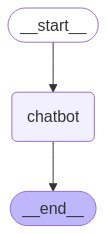

In [3]:
# Import modules for chatbot diagram
from IPython.display import Image, display

# Try generating and displaying the graph diagram
try:
    display(Image(graph.get_graph().draw_mermaid_png()))

# Return an exception if necessary
except Exception:
    print("Additional dependencies required.")

## **Adding external tools to a chatbot**

Now let's try incorporating an external API tool into our chatbot. 

Tools with API capabilities help augment chatbot agents by enabling access to external resources, such as

- news
- databases
- social media
- etc.

### **Adding a Wikipedia tool**

Using LangGraph, let's expand our education chatbot's knowledge by including a _Wikipedia API_.

We'll start with two modules:

- `from langchain_community.utilities import WikipediaAPIWrapper` allows us to interact with the Wikipedia API,
- `from langchain_community.tools import WikipediaQueryRun` enables us to run queries on Wikipedia. WikipediaQueryRun makes the API a tool for running queries. 

Next, we'll initialize `WikipediaAPIWrapper`, setting `top_k_results` to one to keep responses relevant. Then, we'll create `wikipedia_tool` with `WikipediaQueryRun`, passing in the `api_wrapper` to connect directly to Wikipedia and retrieve detailed information when needed. 

Finally, we'll store `wikipedia_tool` in a list called tools, which can hold multiple tools if required.

In [4]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

# initialize Wikipedia API wrapper to fetch top 1 result
api_wrapper = WikipediaAPIWrapper(top_k_results=1)

# Create a Wikipedia query tool using the API wrapper
wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper)
tools = [wikipedia_tool]

We can bind our tools list to the language model using `.bind_tools()` and store it in a variable called `llm_with_tools`.

Next, we'll _update_ our original `chatbot` function to use `llm_with_tools` instead of `llm`, enabling responses from the Wikipedia tool when needed, rather than relying on the language model alone. This modified function passes the full conversation stored in `"messages"` to `llm_with_tools`, allowing the language model to decide when to pull information from Wikipedia to enhance its responses.

In [5]:
# Bind the Wikipedia tool to the language model

llm_with_tools = llm.bind_tools(tools)

# Modify chatbot function to respond with Wikipedia
def chatbot(state: State):
    return{"messages": [llm_with_tools.invoke(state["messages"])]}

### **Other API tools**

For more details on how to add different tools with external APIs, be sure to reference LangChain's [API documentation](https://python.langchain.com/docs/integrations/tools/).

## **Adding tool nodes**

Now that we have our Wikipedia tool, the next modules we need to import are `ToolNode` and `tools_condition` from `graph_tool_nodes`. These modules will help us add the tool to our chatbot's graph. As with the basic chatbot, we'll start by adding our chatbot node labeled `"chatbot"` to the `graph_builder` using the `.add_node()` method.

Then we'll define a tool_node by passing in the `wikipedia_tool` to the tools argument in LangGraph's `ToolNode()` class, before adding this node labeled `"tools"` to the `graph_builder`.


<div style="display: flex;">
    <!-- Left Column -->
    <div style="width: 45%; padding: 10px;">
    Next, before adding an <b>END</b> node explicitly, we'll use the <b>.add_conditional_edges()</b> method with <b>tools_condition</b> to let the chatbot decide if a tool is needed. If it is, the chatbot will call a tool. If not, the chatbot will end without a response.<br><br>

For LLM or tool calls that generate a response, we'll connect <b>"tools"</b> back to the <b>"chatbot"</b> using the <b>.add_edge()</b> method, then add a <b>START</b> node which connects to the <b>"chatbot"</b>, before finally connecting the <b>"chatbot"</b> to the added <b>END</b> node.
    </div>
    <!-- Right Column -->
    <div style="width: 48%; padding: 10px;">
        <img src='./images/conditional.svg' width=48%>
    </div>
</div>



In [21]:
# Modules for adding tool conditions and nodes
from langgraph.prebuilt import ToolNode, tools_condition

# Add chatbot node to the graph after Reinitializing the graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

# Create a ToolNode to handle tool calls and add it to the graph
tool_node = ToolNode(tools=[wikipedia_tool])
graph_builder.add_node("tools", tool_node)


# Set up a condition to direct from chatbot to tool or end node
graph_builder.add_conditional_edges("chatbot", tools_condition)

# Connect tools back to chatbot and add START and END nodes
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

## **Adding memory and conversation**

We'll use our graph display function to check the graph without the try-except block, since we've already tested this feature. 

Then, we'll set up our streaming function now labeled `stream_tool_responses`, to see if the tool was correctly called. Inside this function, we'll access the messages stored in the chatbot's events, which should refer to specific tools. Finally, we'll pass a test query, `"House of Lords"`.

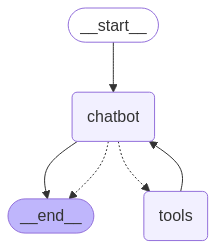

Agent: [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_urN9RHNTVuzgBOr44eKLQTAA', 'function': {'arguments': '{"query":"House of Lords"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 84, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2d901d94-a4da-48b7-bcdf-01171afe9431-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'House of Lords'}, 'id': 'call_urN9RHNTVuzgBOr44eKLQTAA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 16, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'a

In [24]:
# Produce the chatbot graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Define a function to execute the chatbot, streaming each message
def stream_tool_responses(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Agent:", value["messages"])

# Define the query and run the chatbot
user_query = "House of Lords"
stream_tool_responses(user_query)

The diagram shows the tools node added, with all nodes and edges correctly implemented, reflecting all of the possible conversation outcomes.

The abbreviated output shows the test query passed to the chatbot, along with the Wikipedia tool call in the metadata field called `"name"`. The next response shows a summary generated from the _House of Lords_ Wikipedia page. The chatbot's final answer modifies the content from the Wikipedia summary using the LLM to enhance the clarity of its response. Additional details appear in the response_metadata field. 

### **Adding memory**

Rather than independently responding to different queries, let's add memory to our chatbot so it can maintain a conversation. 

First, we'll import `MemorySaver` from `langgraph.checkpoint.memory` to handle memory storage within our graph. 

Then, we'll create a `MemorySaver` instance called `memory`, which will act as our checkpoint for storing messages. 

Next, we'll compile the graph with `graph_builder.compile()`, passing memory as the checkpoint, so the chatbot retains conversation context.

### **Streaming outputs with memory**

To set up a chatbot that remembers context, we'll define a streaming function called `stream_memory_responses` for a single conversation.

First, we'll create a `config` dictionary with a unique thread ID, `"single_session_memory"`, which lets us maintain message history.

Next, we'll use a for loop to stream events from the graph using `.stream()`, passing in the user’s input message along with the config dictionary.

Finally, we'll extract and print the agent's last response by checking for messages in each event's values, allowing the chatbot to answer follow-up questions with context.

In [28]:
# Import the modules for saving memory
from langgraph.checkpoint.memory import MemorySaver

# Modify the graph with memory checkpointing
memory = MemorySaver()

# Compile the graph passing in memory
graph = graph_builder.compile(checkpointer=memory)

# Set up a streaming function for a single user
def stream_memory_responses(user_input: str):
    config = {"configurable": {"thread_id": "single_session_memory"}}

    # Stram the events in the graph
    for event in graph.stream({"messages": [("user", user_input)]}, config):

        # Return the agent's last response
        for value in event.values():
            if "messages" in value and value["messages"]:
                print("Agent:", value["messages"])

stream_memory_responses("What is the Colosseum?")
stream_memory_responses("who built it?")

Agent: [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w0NXrEmFBpeZZyQeH4qdl0V5', 'function': {'arguments': '{"query":"Colosseum"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 88, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a3fa2f8f-eb49-41a6-881e-872f9721161d-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Colosseum'}, 'id': 'call_w0NXrEmFBpeZZyQeH4qdl0V5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 88, 'output_tokens': 16, 'total_tokens': 104, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 

### **Generating output with memory**

Let's inspect the output! 

First, the chatbot processes the query and calls the Wikipedia tool to retrieve information on the Colosseum. 

Then it provides a summary, describing the Colosseum as Rome’s largest ancient amphitheater. 

Next, the chatbot answers, explaining it was built by Emperor Vespasian for gladiatorial events.

Since we passed config parameters for a single session of memory, the chatbot answers the follow-up question with the same tool, noting completion under Titus and modifications under Domitian.